In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re

from scipy.stats import friedmanchisquare
from subprocess import check_output
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [3]:
%matplotlib inline
matplotlib.style.use('ggplot')

In [4]:
def parseFloat(x):
    try:
        x = float(x)
    except:
        x = 0
    return x

def parseStringCommas(x):
    try:
        x = int(x.replace(',',''))
    except:
        x = 0
    return x

def parseStringModulus(x):
    try:
        x = int(x.replace('%',''))
    except:
        x = 0
    return x

def convertToInt(x):
    try:
        x = int(x)
    except:
        x = 0
    return x


In [5]:
# Read the three primary datasets
shanghai = pd.read_csv('Data/shanghaiData.csv')
cwur = pd.read_csv('Data/cwurData.csv')
times = pd.read_csv('Data/timesData.csv')

In [6]:
# Make column names uniform all throughout
shanghai = shanghai.rename(columns = {'total_score': 'score'})
cwur = cwur.rename(columns = {'institution': 'university_name'#, 'score': 'score_cwur'
                             })
times = times.rename(columns = {'total_score': 'score'})

In [7]:
# Filter year variable and include data only from 2012 onwards
shang2012gre = shanghai[(shanghai.year >= 2012)]
times2012gre = times[(times.year >= 2012)]

In [8]:
# Get unique schools
unishang = shang2012gre.university_name.unique()
unitimes = times2012gre.university_name.unique()
unicwur = cwur.university_name.unique()

In [9]:
# Get common schools among the three WITHOUT cleaning university column
communi = set(unicwur).intersection(unitimes).intersection(unishang)

In [10]:
filtshang = shang2012gre[shang2012gre['university_name'].isin(communi)]
filttimes = times2012gre[times2012gre['university_name'].isin(communi)]
filtcwur = cwur[cwur['university_name'].isin(communi)]

smolshang = filtshang[["university_name", "score", "year"]]
smoltimes = filttimes[["university_name", "score", "year"]]
smolcwur = filtcwur[["university_name", "score", "year"]]

In [11]:
# Year 2012 only
shang2012 = smolshang[(smolshang.year == 2012)]
times2012 = smoltimes[(smoltimes.year == 2012)]
cwur2012 = smolcwur[(smolcwur.year == 2012)]

shang2012 = shang2012[["university_name", "score"]]
times2012 = times2012[["university_name", "score"]]
cwur2012 = cwur2012[["university_name", "score"]]

shang2012['institution'] = "shanghai"
times2012['institution'] = "times"
cwur2012['institution'] = "cwur"

In [12]:
all2012 = pd.concat([times2012, shang2012, cwur2012], ignore_index=True)

all2012 = all2012.replace({'-': ''}, regex=True)
all2012[['score']] = all2012[['score']].apply(lambda x: pd.to_numeric(x, errors='ignore'))
all2012.dtypes

print(all2012[:5])

                      university_name  score institution
0  California Institute of Technology   94.8       times
1                  Harvard University   93.9       times
2                 Stanford University   93.9       times
3                University of Oxford   93.6       times
4                Princeton University   92.9       times


In [13]:
all2012 = all2012.fillna(0)
a2012 = all2012[all2012['score'] > 0]

In [14]:
# We get only the universities who have ratings from the 3 institutions.
s = a2012.groupby(['university_name']).transform('count')['score']
a2012['count'] = pd.Series(s)
a2012 = a2012[ a2012['count'] == 3 ]

C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


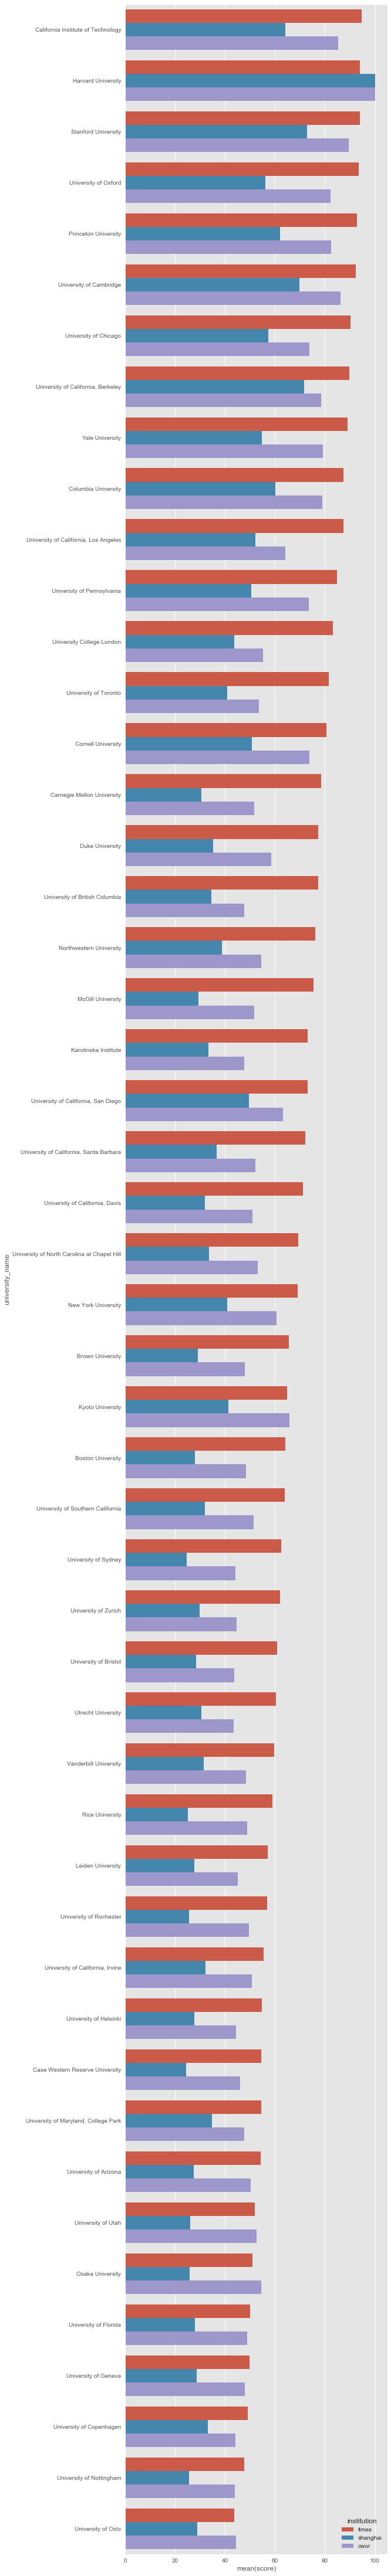

In [15]:
f, ax = plt.subplots(figsize=(8,80))
sns.barplot(y='university_name', x="score", hue="institution", data=a2012, orient='h')

In [ ]:
times['female'] = times['female_male_ratio'].str.split(':', expand=True)[0].apply(convertToInt)
times['male'] = times['female_male_ratio'].str.split(':', expand=True)[1].apply(convertToInt)
times['sex_ratio'] =  np.where(times['male'] == 0, 0, times['male']/times['female'])

In [ ]:
columnstoFloat = ['world_rank', 'teaching', 'international', 'research', 'citations', 'income', 'score', 'student_staff_ratio']  

for column in columnstoFloat:
    times[column] = times[column].apply(parseFloat)

In [ ]:
times['num_students'] = times['num_students'].apply(parseStringCommas)
times['year'] = times['year'].apply(lambda x : int(x))
times['international_students'] = times['international_students'].apply(parseStringModulus)

In [ ]:
cleanData = times[(times.world_rank != 0) & (times.year == 2015)][['world_rank', 'teaching', 'international', 'research', 'citations', 'income', 'score', 'sex_ratio']]

In [ ]:
cleanData

In [ ]:
import seaborn as sns

f = lambda x: int((int(x.split('-')[0]) + int(x.split('-')[1])) / 2) if len(str(x).strip()) > 3 else x

#cleanData['world_rank'] = cleanData['world_rank'].str.replace('=','').map(f).astype('float')
vis2 = sns.lmplot(data=times, x='score', y='world_rank', fit_reg=False, hue='year', size=7, aspect=1)

In [ ]:
cleanData.plot(y='world_rank', x = 'research', kind='scatter', xlim=(0,110))
cleanData.plot(y='world_rank', x = 'sex_ratio', kind='scatter')
#scatter_matrix(cleanData, alpha=0.5, figsize=(15,15), diagonal='kde')

In [ ]:
train, test = train_test_split(cleanData, test_size = 0.3)

features = train[['teaching','international', 'research', 'citations', 'sex_ratio']]
y = train['score']
lm = LinearRegression()
lm.fit(features, y)

In [ ]:
print( 'Coefficients',lm.coef_)

In [ ]:
print( 'Intercept', lm.intercept_)
print( 'RSquared', lm.score(features, y))

In [ ]:
output = pd.DataFrame(lm.predict(test[['teaching','international', 'research', 'citations', 'sex_ratio']]), columns =['Prediction'])
output['Actual'] = test['score'].reset_index(drop=True)
print(output.head())

In [ ]:
rf = RandomForestRegressor(n_estimators=20)
rf.fit(features, y)

In [ ]:
print( 'RSquared', rf.score(features, y))

In [ ]:
output = pd.DataFrame(rf.predict(test[['teaching','international', 'research', 'citations', 'sex_ratio']]), columns =['Prediction'])
output['Actual'] = test['score'].reset_index(drop=True)
print(output.head())

In [ ]:
nn = MLPRegressor()
nn.fit(features, y)

In [ ]:
print( 'RSquared', nn.score(features, y))

In [ ]:
output = pd.DataFrame(nn.predict(test[['teaching','international', 'research', 'citations', 'sex_ratio']]), columns =['Prediction'])
output['Actual'] = test['score'].reset_index(drop=True)
print(output.head())